In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/acc-minute-data-with-indicators/ACC_minute_data_with_indicators.csv


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [3]:
#load data
csv_file = '/kaggle/input/acc-minute-data-with-indicators/ACC_minute_data_with_indicators.csv'
data= pd.read_csv(csv_file)
data.describe()

,close,high,low,open,volume,sma5,sma10,sma15,sma20,ema5,...,fastd,fastksr,fastdsr,ULTOSC,WILLR,ATR,Trange,TYPPRICE,HT_DCPERIOD,BETA
count,660533.000000,660533.000000,660533.000000,660533.000000,660533.000000,660533.000000,660533.000000,660533.000000,660533.000000,660533.000000,...,6.605330e+05,660533.000000,6.605330e+05,660533.000000,660533.000000,660533.000000,660533.000000,660533.000000,660533.000000,660533.000000
mean,1647.463103,1648.378130,1646.548347,1647.469821,1681.772802,1647.460952,1647.458268,1647.455589,1647.452907,1647.460953,...,4.949091e+01,49.598631,4.959855e+01,49.721788,-50.573234,1.866714,1.866721,1647.463193,21.049242,0.392300
std,328.577858,328.764984,328.380671,328.578274,4955.211234,328.572711,328.567239,328.561910,328.556631,328.571143,...,2.607893e+01,41.329888,3.158735e+01,12.962223,29.953232,1.056432,1.803807,328.573653,5.066249,0.919547
min,896.500000,899.100000,895.150000,896.000000,0.000000,898.430000,899.700000,900.923333,902.532500,899.551920,...,-7.999527e-12,0.000000,-4.073778e-13,0.000000,-100.000000,0.061538,0.000000,897.866667,6.259652,-32.155826
25%,1419.250000,1420.000000,1418.550000,1419.300000,243.000000,1419.310000,1419.325000,1419.300000,1419.315000,1419.327198,...,2.775362e+01,0.000000,2.259152e+01,40.944619,-76.256983,1.199861,0.900000,1419.316667,17.393558,0.008550
50%,1565.650000,1566.500000,1565.000000,1565.650000,675.000000,1565.610000,1565.585000,1565.580000,1565.560000,1565.615006,...,4.923969e+01,49.183618,4.938758e+01,49.776458,-50.847458,1.625687,1.500000,1565.650000,20.185634,0.326838
75%,1766.450000,1767.300000,1765.500000,1766.500000,1720.000000,1766.410000,1766.405000,1766.413333,1766.427500,1766.395762,...,7.115276e+01,100.000000,7.632192e+01,58.617944,-25.000000,2.239663,2.350000,1766.450000,23.787294,0.703842
max,2782.650000,2785.000000,2762.000000,2785.000000,962709.000000,2758.840000,2757.160000,2756.050000,2754.742500,2759.451431,...,1.000000e+02,100.000000,1.000000e+02,96.502976,-0.000000,19.459262,208.100000,2776.350000,47.436655,40.543815


In [4]:
data.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'sma5', 'sma10',
       'sma15', 'sma20', 'ema5', 'ema10', 'ema15', 'ema20', 'upperband',
       'middleband', 'lowerband', 'HT_TRENDLINE', 'KAMA10', 'KAMA20', 'KAMA30',
       'SAR', 'TRIMA5', 'TRIMA10', 'TRIMA20', 'ADX5', 'ADX10', 'ADX20', 'APO',
       'CCI5', 'CCI10', 'CCI15', 'macd510', 'macd520', 'macd1020', 'macd1520',
       'macd1226', 'MFI', 'MOM10', 'MOM15', 'MOM20', 'ROC5', 'ROC10', 'ROC20',
       'PPO', 'RSI14', 'RSI8', 'slowk', 'slowd', 'fastk', 'fastd', 'fastksr',
       'fastdsr', 'ULTOSC', 'WILLR', 'ATR', 'Trange', 'TYPPRICE',
       'HT_DCPERIOD', 'BETA'],
      dtype='object')

In [5]:
data.dropna(axis=0)

,date,close,high,low,open,volume,sma5,sma10,sma15,sma20,...,fastd,fastksr,fastdsr,ULTOSC,WILLR,ATR,Trange,TYPPRICE,HT_DCPERIOD,BETA
0,2015-02-02 10:18:00+05:30,1544.00,1545.00,1543.10,1545.00,220,1544.94,1545.890,1546.756667,1546.9950,...,31.307634,0.000000,8.760123e+00,43.728004,-86.466165,2.056306,2.10,1544.033333,27.840336,0.138547
1,2015-02-02 10:19:00+05:30,1543.70,1544.00,1543.00,1544.00,29,1544.63,1545.545,1546.446667,1546.8650,...,23.381708,0.000000,4.380062e+00,47.390635,-89.629630,1.980855,1.00,1543.566667,27.115144,0.094738
2,2015-02-02 10:20:00+05:30,1543.00,1543.70,1542.50,1543.70,28,1544.22,1545.205,1546.013333,1546.5800,...,15.620034,0.000000,1.184238e-15,43.139523,-92.857143,1.925080,1.20,1543.066667,26.735549,0.336124
3,2015-02-02 10:21:00+05:30,1542.30,1543.00,1542.30,1543.00,125,1543.64,1544.635,1545.533333,1546.3950,...,9.497585,0.000000,1.184238e-15,44.657886,-100.000000,1.837574,0.70,1542.533333,26.601907,0.608042
4,2015-02-02 10:22:00+05:30,1542.10,1542.15,1541.10,1541.10,113,1543.02,1544.235,1545.143333,1546.0725,...,13.377926,0.000000,1.184238e-15,54.066603,-86.111111,1.792033,1.20,1541.783333,26.691996,0.253168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660528,2022-10-24 19:10:00+05:30,2255.00,2255.90,2254.55,2255.80,199,2254.57,2255.310,2256.563333,2257.6950,...,49.178125,81.874937,7.598390e+01,45.272781,-70.652174,2.447174,1.35,2255.150000,21.097032,0.264783
660529,2022-10-24 19:11:00+05:30,2255.95,2255.95,2254.55,2255.75,227,2255.01,2255.170,2256.296667,2257.5225,...,77.569938,100.000000,9.395831e+01,50.828265,-60.326087,2.372376,1.40,2255.483333,21.480192,-0.180632
660530,2022-10-24 19:12:00+05:30,2256.25,2256.25,2255.35,2256.00,594,2255.21,2255.025,2256.046667,2257.2600,...,90.435435,100.000000,9.395831e+01,63.508973,-52.976190,2.267206,0.90,2255.950000,21.961213,-0.825419
660531,2022-10-24 19:13:00+05:30,2255.00,2255.95,2254.55,2255.50,267,2255.60,2254.820,2255.656667,2256.9350,...,86.623932,14.162538,7.138751e+01,60.803143,-53.043478,2.226691,1.70,2255.166667,22.556313,0.117191


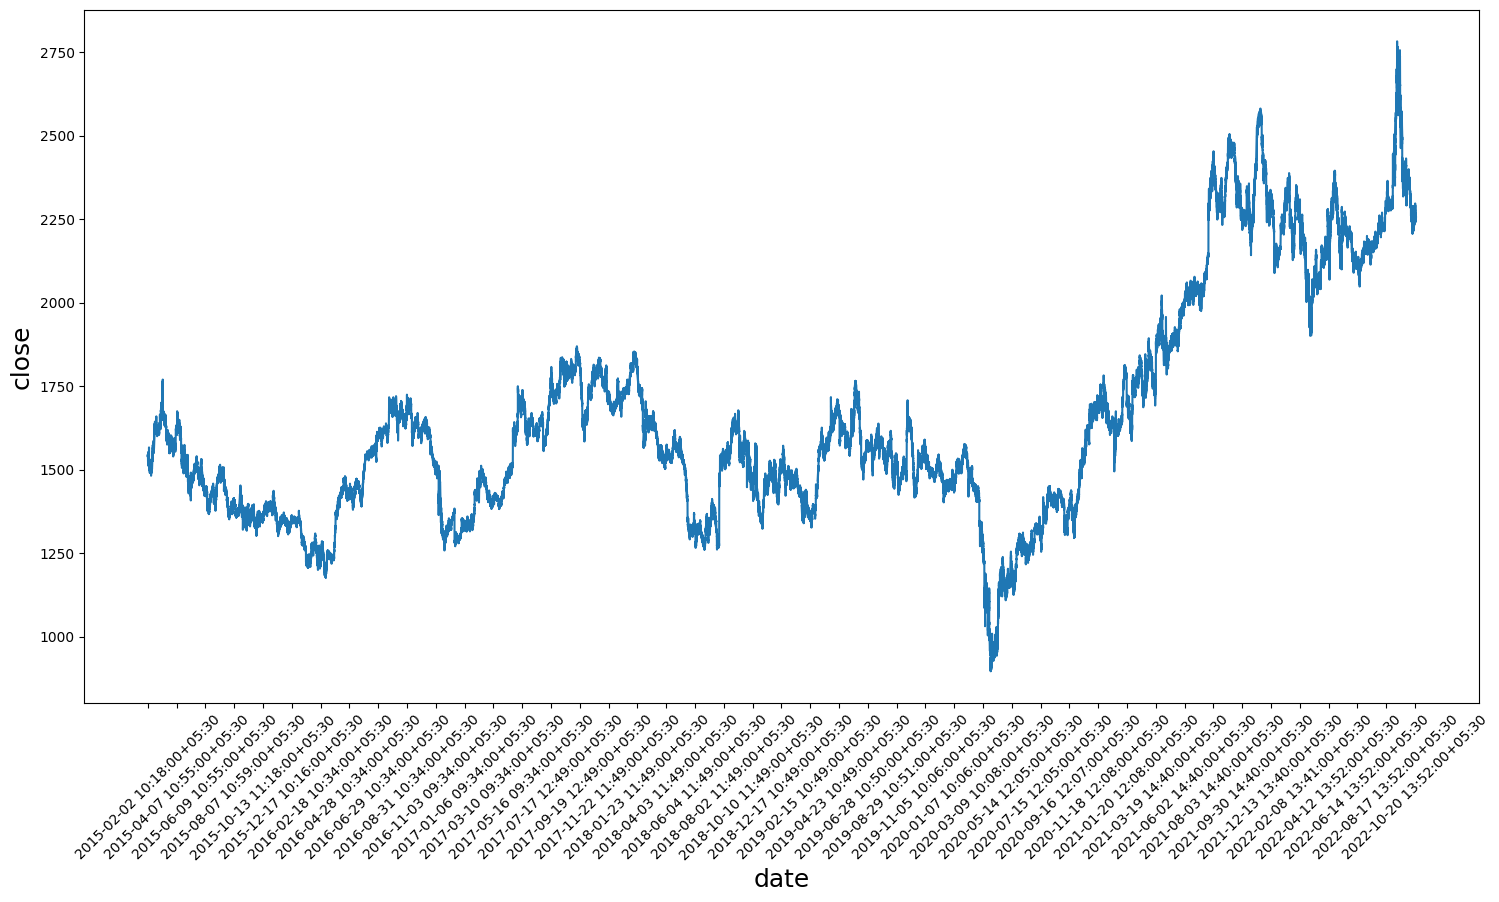

In [6]:
plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]),(data['close']))
plt.xticks(range(0,data.shape[0],15000),data['date'].loc[::15000],rotation=45)
plt.xlabel('date',fontsize=18)
plt.ylabel('close',fontsize=18)
plt.show()


The columns that are inputted into our model (and later used to make predictions) are called "features

In [7]:
data_features = ['open', 'high', 'low', 'close', 'volume']
data = data[data_features]
data.describe()

,open,high,low,close,volume
count,660533.000000,660533.000000,660533.000000,660533.000000,660533.000000
mean,1647.469821,1648.378130,1646.548347,1647.463103,1681.772802
std,328.578274,328.764984,328.380671,328.577858,4955.211234
min,896.000000,899.100000,895.150000,896.500000,0.000000
25%,1419.300000,1420.000000,1418.550000,1419.250000,243.000000
50%,1565.650000,1566.500000,1565.000000,1565.650000,675.000000
75%,1766.500000,1767.300000,1765.500000,1766.450000,1720.000000
max,2785.000000,2785.000000,2762.000000,2782.650000,962709.000000


In [8]:
data.head(11)

,open,high,low,close,volume
0,1545.00,1545.00,1543.10,1544.00,220
1,1544.00,1544.00,1543.00,1543.70,29
2,1543.70,1543.70,1542.50,1543.00,28
3,1543.00,1543.00,1542.30,1542.30,125
4,1541.10,1542.15,1541.10,1542.10,113
5,1542.10,1542.10,1541.00,1541.00,87
6,1541.00,1541.00,1540.35,1540.35,101
7,1540.35,1543.15,1540.35,1543.15,120
8,1543.15,1543.30,1540.90,1540.90,460
9,1540.90,1542.05,1540.35,1542.00,105


In [9]:
data = data[['open', 'high', 'low', 'close', 'volume']]
train_size = int(0.8 * len(data))
train_data = data[:train_size].values
test_data = data[train_size:].values

# Normalize Data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)



In [10]:
train_data


array([[5.76863251e-01, 5.74874282e-01, 5.78630113e-01, 5.75402115e-01,
        2.36492261e-04],
       [5.75974401e-01, 5.73984246e-01, 5.78540811e-01, 5.75135519e-01,
        3.11739798e-05],
       [5.75707746e-01, 5.73717236e-01, 5.78094303e-01, 5.74513463e-01,
        3.00990150e-05],
       ...,
       [9.44935781e-01, 9.44239242e-01, 9.48205037e-01, 9.43304008e-01,
        4.70834592e-03],
       [9.43958046e-01, 9.43349206e-01, 9.46463654e-01, 9.40638052e-01,
        1.91988717e-03],
       [9.23470068e-01, 9.21943839e-01, 8.94177532e-01, 8.91006843e-01,
        2.12778537e-02]])

In [11]:
print (f"train_data_shape: {train_data.shape}  , test_data_shape: {test_data.shape}")

train_data_shape: (528426, 5)  , test_data_shape: (132107, 5)


In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output


In [13]:
# PositionWiseFeedForward
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))


In [14]:
# PositionalEncoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [15]:
# EncoderLayer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x


In [16]:
# Transformer
class Transformer(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.fc_in = nn.Linear(5, d_model)  # Assuming 5 features in the input data
        self.fc_out = nn.Linear(d_model, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        src = self.fc_in(src)
        src_embedded = self.dropout(self.positional_encoding(src))
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, None)
        output = self.fc_out(enc_output[:, -1, :])  # Use the last time step's output for prediction
        return output

In [17]:
# Dataset Preparation
class StockPriceDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length, :]
        y = self.data[idx+self.seq_length, 3]  # Use the 'close' price as the target
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [18]:
# Create Datasets and DataLoaders
seq_length = 10
train_dataset = StockPriceDataset(train_data, seq_length)
test_dataset = StockPriceDataset(test_data, seq_length)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [19]:
# Model Parameters
d_model = 256
num_heads = 4
num_layers = 6
d_ff = 1024
max_seq_length = seq_length
dropout = 0.1

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer(d_model, num_heads, num_layers, d_ff, max_seq_length, dropout).to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.001)

In [20]:
# Training
model.train()
for epoch in range(10): 
    epoch_loss = 0
    for i, (src, tgt) in enumerate(train_loader):
        # Print src and tgt values and shapes for the first two rows of the first batch in the first epoch
        if epoch == 0 and i == 0:  
            for j in range(min(2, len(src))):
                print(f"src[{j}]: {src[j]}, shape: {src[j].shape}")
                print(f"tgt[{j}]: {tgt[j]}, shape: {tgt[j].shape}")

        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = model(src)
        loss = criterion(output.squeeze(), tgt)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    print(f"Epoch {epoch+1}/{10}, Loss: {epoch_loss/len(train_loader)}")

# The model output and target shapes
print(f"Output shape: {output.shape}, Target shape: {tgt.shape}")
print(output)


src[0]: tensor([[5.3238e-01, 5.3033e-01, 5.3554e-01, 5.3181e-01, 2.2682e-04],
        [5.3233e-01, 5.3082e-01, 5.3554e-01, 5.3230e-01, 3.1281e-04],
        [5.3287e-01, 5.3082e-01, 5.3590e-01, 5.3226e-01, 1.1072e-04],
        [5.3282e-01, 5.3122e-01, 5.3603e-01, 5.3270e-01, 1.3222e-04],
        [5.3327e-01, 5.3122e-01, 5.3635e-01, 5.3270e-01, 1.8812e-04],
        [5.3327e-01, 5.3122e-01, 5.3648e-01, 5.3270e-01, 2.2112e-03],
        [5.3327e-01, 5.3122e-01, 5.3644e-01, 5.3270e-01, 5.3748e-04],
        [5.3327e-01, 5.3122e-01, 5.3644e-01, 5.3270e-01, 2.0102e-04],
        [5.3322e-01, 5.3122e-01, 5.3608e-01, 5.3230e-01, 2.4832e-04],
        [5.3287e-01, 5.3117e-01, 5.3599e-01, 5.3221e-01, 1.7414e-04]]), shape: torch.Size([10, 5])
tgt[0]: 0.5323024988174438, shape: torch.Size([])
src[1]: tensor([[6.8824e-01, 6.8778e-01, 6.9204e-01, 6.8853e-01, 2.2295e-03],
        [6.8912e-01, 6.8791e-01, 6.9245e-01, 6.8857e-01, 1.4093e-03],
        [6.8917e-01, 6.8871e-01, 6.9231e-01, 6.8995e-01, 2.9486e-

In [21]:
# Evaluation and Prediction
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for src, tgt in test_loader:
        src, tgt = src.to(device), tgt.to(device)
        tgt = tgt.unsqueeze(0)
        tgt = tgt.transpose(0, 1)
        output = model(src)
        predictions.append(output.cpu().numpy())
        actuals.append(tgt.cpu().numpy())
print(f"Output shape: {output.shape}, Target shape: {tgt.shape}")


Output shape: torch.Size([32, 1]), Target shape: torch.Size([32, 1])


In [22]:
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for src, tgt in test_loader:
        src, tgt = src.to(device), tgt.to(device)
        
        # Forward pass
        output = model(src)
        
        # Ensure output and tgt are at least 2-dimensional
        if output.dim() == 1:
            output = output.unsqueeze(1)
        if tgt.dim() == 1:
            tgt = tgt.unsqueeze(1)
        
        # Append to lists
        predictions.append(output.cpu().numpy())
        actuals.append(tgt.cpu().numpy())

# Convert lists of arrays to single arrays
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# Ensure predictions and actuals have the same length
actuals = actuals[:132107]
predictions = predictions[:len(actuals)]

# Debugging: Check shapes before concatenation
print(f"Predictions shape: {predictions.shape}, Actuals shape: {actuals.shape}")

# Assuming test_data is available and scaled
# Make sure test_data has enough samples

# Extract test data features correctly and ensure they are 2D
test_data_features = test_data[:len(predictions), :-1]

# Debugging: Check shapes of arrays to be concatenated
print(f"Test data features shape: {test_data_features.shape}, Predictions reshaped: {predictions.reshape(-1, 1).shape}")

# Inverse transform to get original scale for predictions
predictions_combined = np.concatenate([test_data_features, predictions.reshape(-1, 1)], axis=1)
predictions = scaler.inverse_transform(predictions_combined)[:, -1]

# Repeat for actuals
test_data_features_actuals = test_data[:len(actuals), :-1]
actuals_combined = np.concatenate([test_data_features_actuals, actuals.reshape(-1, 1)], axis=1)
print(f"Test data features for actuals shape: {test_data_features_actuals.shape}, Actuals reshaped: {actuals.reshape(-1, 1).shape}")

actuals = scaler.inverse_transform(actuals_combined)[:, -1]

print(f"Final Predictions shape: {predictions.shape}, Final Actuals shape: {actuals.shape}")


Predictions shape: (132107, 1), Actuals shape: (132107, 1)
Test data features shape: (132107, 4), Predictions reshaped: (132107, 1)
Test data features for actuals shape: (132107, 4), Actuals reshaped: (132107, 1)
Final Predictions shape: (132107,), Final Actuals shape: (132107,)


In [23]:
predictions

array([550858.31534219, 550858.31534219, 550858.31534219, ...,
       550858.31534219, 550858.31534219, 550858.31534219])

In [24]:
actuals

array([312113.02484557, 770837.75846273, 420573.43523747, ...,
       436941.71128109, 369153.95825166, 449300.57048234])

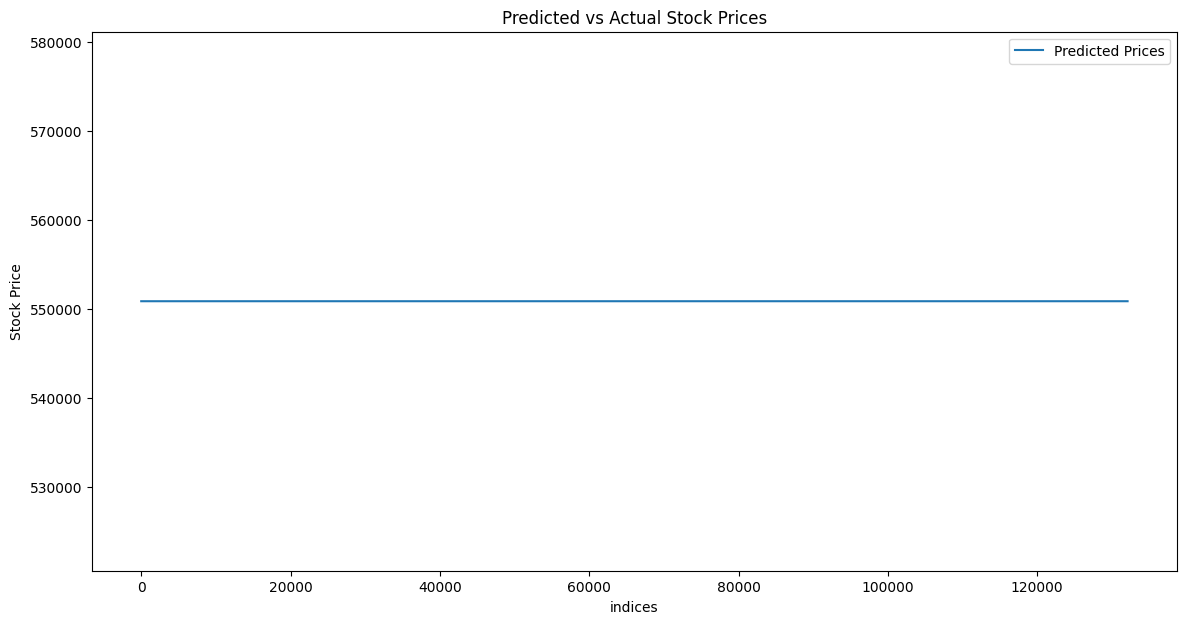

In [25]:
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(predictions, label='Predicted Prices')
plt.title('Predicted vs Actual Stock Prices')
plt.xlabel('indices')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


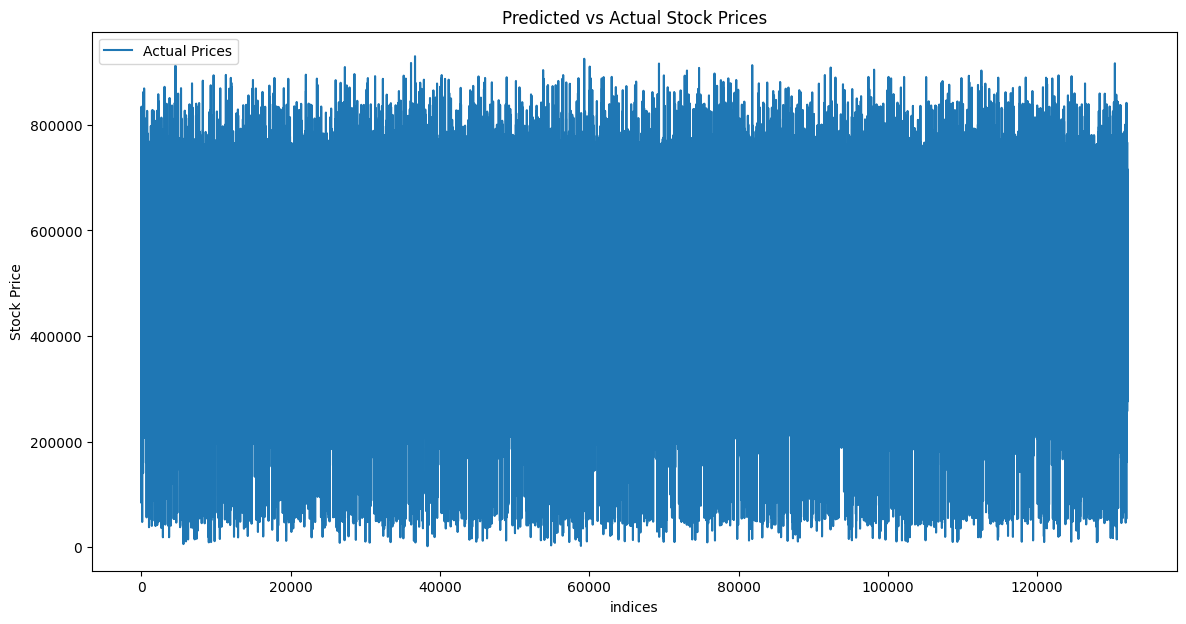

In [26]:
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual Prices')
plt.title('Predicted vs Actual Stock Prices')
plt.xlabel('indices')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
# Example DataFrame setup
import pandas as pd

# Assuming 'data' is your DataFrame and it contains 'embeddings' and 'label' columns
# Let's say each embedding is already a tensor
# Convert embeddings list to tensors if not already (if they are numpy arrays or lists)
data['embeddings'] = data['embeddings'].apply(torch.tensor)

# Create a list of embeddings and a list of labels
embeddings = list(data['embeddings'])
labels = list(data['Category'])  # Ensure labels are appropriate for your task (e.g., 0 and 1 for binary classification)

# Instantiate your custom dataset
dataset = TextEmbeddingDataset(embeddings, labels)


In [ ]:
# Assuming 'data' is your pandas DataFrame containing 'Category' and 'embeddings' columns
data = data[['Category', 'embeddings']]

# Convert embeddings to a list of arrays (assuming they are already torch tensors or numpy arrays)
embeddings = list(data['embeddings'].values)
labels = list(data['Category'].values)

# Convert embeddings list to tensors if not already (if they are numpy arrays or lists)
embeddings = [torch.tensor(embedding) for embedding in embeddings]

# Convert labels to appropriate type (e.g., for binary classification)
labels = np.array(labels)  # Ensure labels are numpy array for indexing

# Split data into train and test sets
train_size = int(0.8 * len(data))
train_embeddings, train_labels = embeddings[:train_size], labels[:train_size]
test_embeddings, test_labels = embeddings[train_size:], labels[train_size:]

